In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from cuml.manifold import TSNE
import cupy as cp
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv("/content/drive/MyDrive/Datasets/cardio_train.csv", sep=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [4]:
df.drop('id', axis=1, inplace=True)

In [5]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df.isnull().sum()

,0
age,0
gender,0
height,0
weight,0
ap_hi,0
ap_lo,0
cholesterol,0
gluc,0
smoke,0
alco,0


In [7]:
# 1) Age conversion
df['age'] = (df['age'] / 365).round(1)

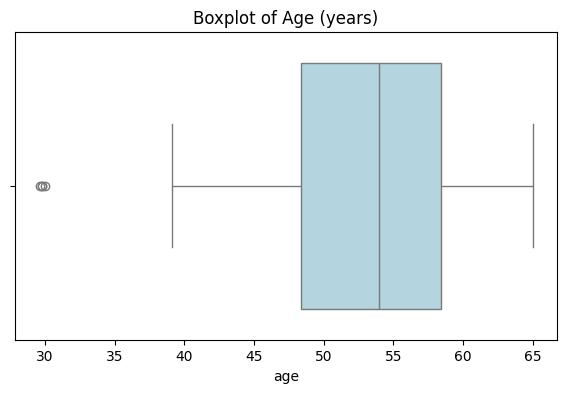

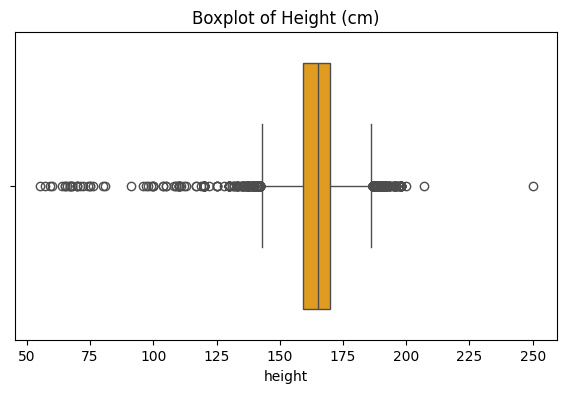

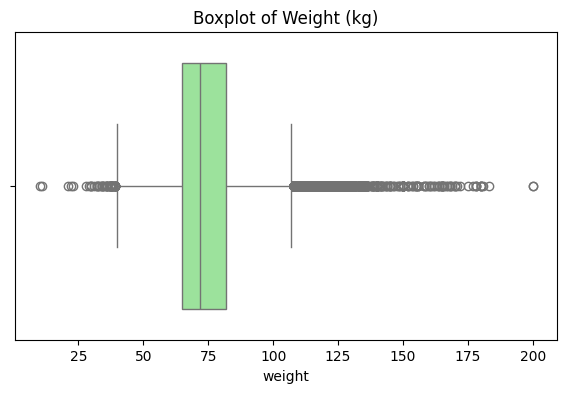

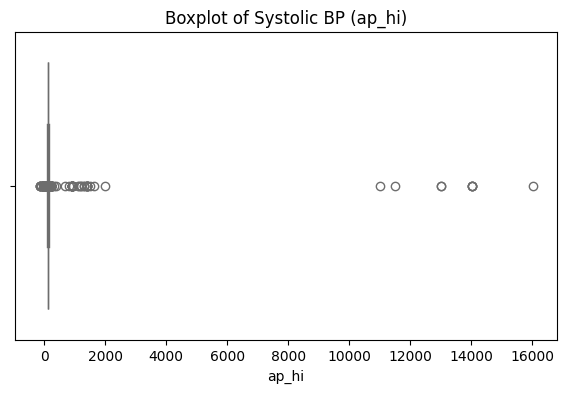

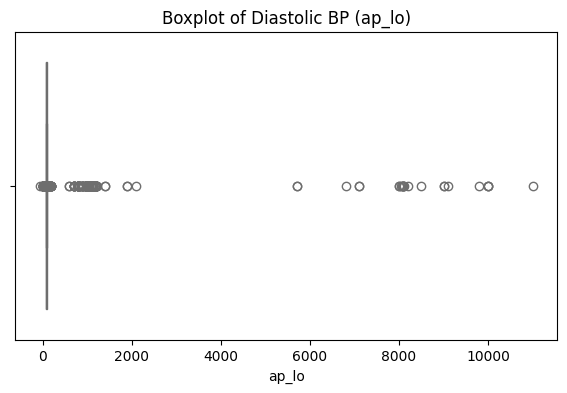

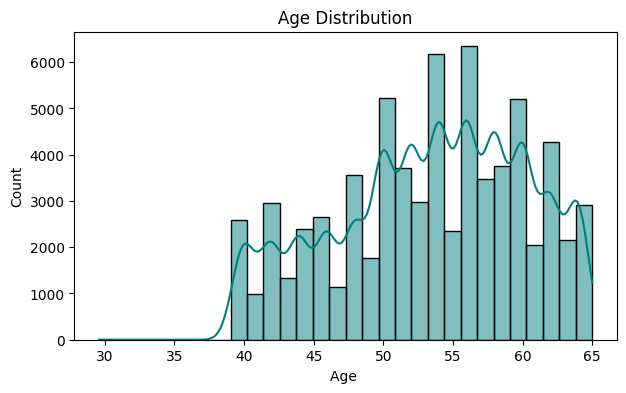

In [8]:
# 2) Visualizations (Before Cleaning)
plt.figure(figsize=(7,4))
sns.boxplot(x=df['age'], color='lightblue')
plt.title("Boxplot of Age (years)")
plt.show()

plt.figure(figsize=(7,4))
sns.boxplot(x=df['height'], color='orange')
plt.title("Boxplot of Height (cm)")
plt.show()


plt.figure(figsize=(7,4))
sns.boxplot(x=df['weight'], color='lightgreen')
plt.title("Boxplot of Weight (kg)")
plt.show()

plt.figure(figsize=(7,4))
sns.boxplot(x=df['ap_hi'], color='salmon')
plt.title("Boxplot of Systolic BP (ap_hi)")
plt.show()


plt.figure(figsize=(7,4))
sns.boxplot(x=df['ap_lo'], color='violet')
plt.title("Boxplot of Diastolic BP (ap_lo)")
plt.show()


plt.figure(figsize=(7,4))
sns.histplot(df['age'], bins=30, kde=True, color='teal')
plt.title("Age Distribution")
plt.xlabel("Age ")
plt.ylabel("Count")
plt.show()



In [9]:
# 3) Fix swapped BP values
mask = df['ap_lo'] > df['ap_hi']
df.loc[mask, ['ap_hi', 'ap_lo']] = df.loc[mask, ['ap_lo', 'ap_hi']].values

In [10]:
# 4) Remove Outliers using IQR
Q1_hi = df['ap_hi'].quantile(0.25)
Q3_hi = df['ap_hi'].quantile(0.75)
IQR_hi = Q3_hi - Q1_hi
lower_hi = Q1_hi - 1.5 * IQR_hi
upper_hi = Q3_hi + 1.5 * IQR_hi
df = df[(df['ap_hi'] >= lower_hi) & (df['ap_hi'] <= upper_hi)]

# ap_lo
Q1_lo = df['ap_lo'].quantile(0.25)
Q3_lo = df['ap_lo'].quantile(0.75)
IQR_lo = Q3_lo - Q1_lo
lower_lo = Q1_lo - 1.5 * IQR_lo
upper_lo = Q3_lo + 1.5 * IQR_lo
df = df[(df['ap_lo'] >= lower_lo) & (df['ap_lo'] <= upper_lo)]


df = df[(df['ap_hi'] <= 250) & (df['ap_lo'] <= 200)]

In [11]:
# 5) Remove outliers in height, weight, age using IQR
# Height
Q1_height = df['height'].quantile(0.25)
Q3_height = df['height'].quantile(0.75)
IQR_height = Q3_height - Q1_height
lower_height = Q1_height - 1.5 * IQR_height
upper_height = Q3_height + 1.5 * IQR_height
df = df[(df['height'] >= lower_height) & (df['height'] <= upper_height)]

# Weight
Q1_weight = df['weight'].quantile(0.25)
Q3_weight = df['weight'].quantile(0.75)
IQR_weight = Q3_weight - Q1_weight
lower_weight = Q1_weight - 1.5 * IQR_weight
upper_weight = Q3_weight + 1.5 * IQR_weight
df = df[(df['weight'] >= lower_weight) & (df['weight'] <= upper_weight)]

# Age
Q1_age = df['age'].quantile(0.25)
Q3_age = df['age'].quantile(0.75)
IQR_age = Q3_age - Q1_age
lower_age = Q1_age - 1.5 * IQR_age
upper_age = Q3_age + 1.5 * IQR_age
df = df[(df['age'] >= lower_age) & (df['age'] <= upper_age)]

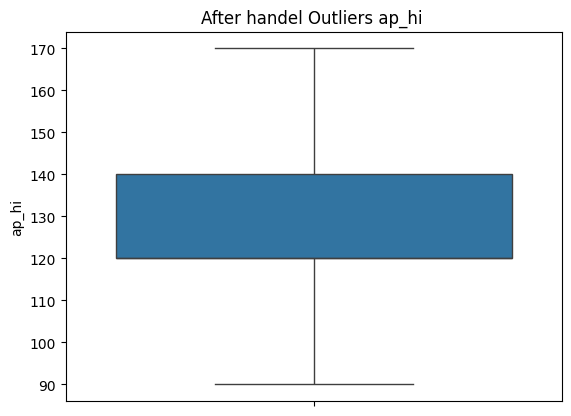

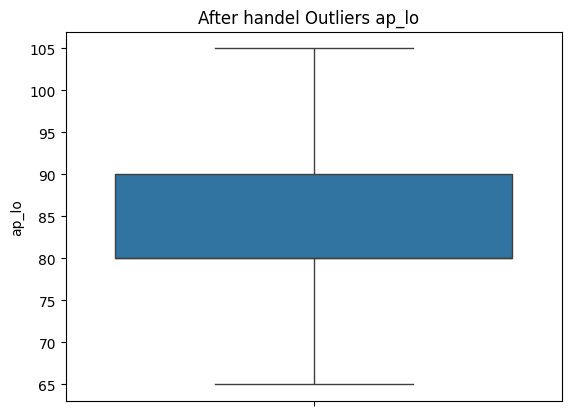

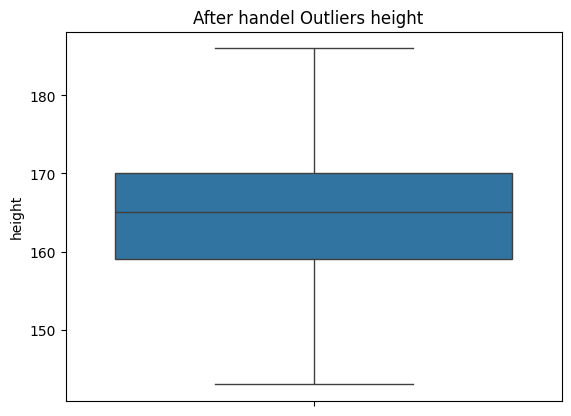

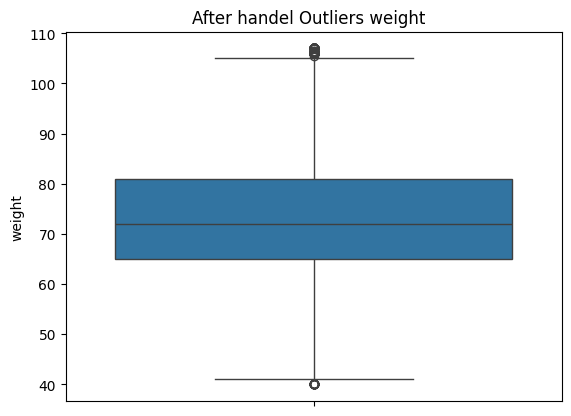

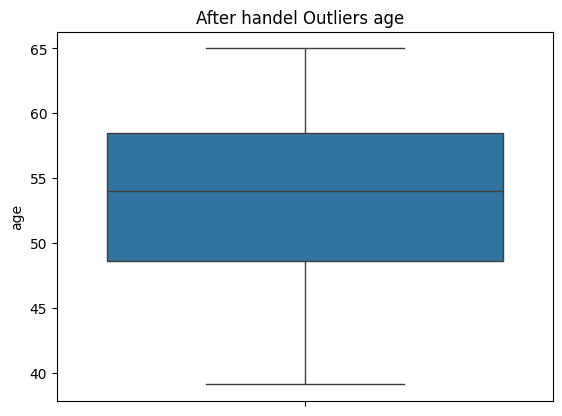

In [12]:
# Visualize after cleaning
sns.boxplot(df['ap_hi'])
plt.title("After handel Outliers ap_hi ")
plt.show()


sns.boxplot(df['ap_lo'])
plt.title("After handel Outliers ap_lo  ")
plt.show()

sns.boxplot(df['height'])
plt.title("After handel Outliers height  ")
plt.show()


sns.boxplot(df['weight'])
plt.title("After handel Outliers weight  ")
plt.show()\


sns.boxplot(df['age'])
plt.title("After handel Outliers age  ")
plt.show()


In [13]:
# 8) Convert categorical features to numbers using LabelEncoder
le = LabelEncoder()
df['cholesterol'] = le.fit_transform(df['cholesterol'])
df['gluc'] = le.fit_transform(df['gluc'])

In [14]:
scaler = RobustScaler()
df[['age', 'height', 'weight']] = scaler.fit_transform(df[['age', 'height', 'weight']])

In [15]:
# 10) Temporal Split using median age
median_age = df['age'].median()
df_train = df[df['age'] < median_age]
df_test = df[df['age'] >= median_age]

X_train = df_train.drop('cardio', axis=1)
y_train = df_train['cardio']
X_test = df_test.drop('cardio', axis=1)
y_test = df_test['cardio']



In [16]:
# 11) Apply SMOTE ONLY ON TRAIN
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("\n Before SMOTE:")
print(y_train.value_counts())

print("\n After SMOTE:")
print(y_train_res.value_counts())


 Before SMOTE:
cardio
0    18577
1    12211
Name: count, dtype: int64

 After SMOTE:
cardio
0    18577
1    18577
Name: count, dtype: int64


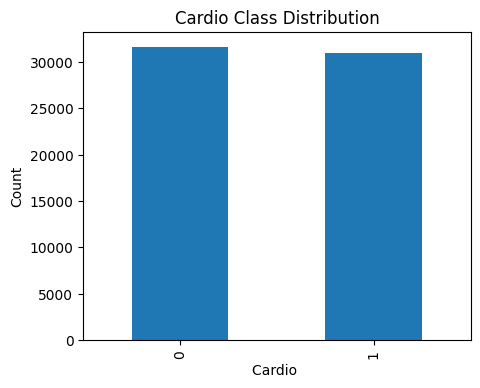

In [17]:
plt.figure(figsize=(5,4))
df['cardio'].value_counts().plot(kind='bar')
plt.title("Cardio Class Distribution")
plt.xlabel("Cardio ")
plt.ylabel("Count")
plt.show()

# Unspervised Learning Task


In [18]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,-0.363636,2,0.272727,-0.6250,110,80,0,0,0,0,1,0
1,0.141414,1,-0.818182,0.8125,140,90,2,0,0,0,1,1
2,-0.232323,1,0.000000,-0.5000,130,70,2,0,0,0,0,1
3,-0.575758,2,0.363636,0.6250,150,100,0,0,0,0,1,1
5,0.606061,1,-1.272727,-0.3125,120,80,1,1,0,0,0,0


In [19]:
features = df.drop(['cardio'], axis=1)

features

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,-0.363636,2,0.272727,-0.6250,110,80,0,0,0,0,1
1,0.141414,1,-0.818182,0.8125,140,90,2,0,0,0,1
2,-0.232323,1,0.000000,-0.5000,130,70,2,0,0,0,0
3,-0.575758,2,0.363636,0.6250,150,100,0,0,0,0,1
5,0.606061,1,-1.272727,-0.3125,120,80,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
69993,0.000000,1,0.636364,-0.1250,130,90,0,0,0,0,1
69994,0.373737,1,0.000000,0.5000,150,80,0,0,0,0,1
69995,-0.131313,2,0.272727,0.2500,120,80,0,0,1,0,1
69998,0.757576,1,-0.181818,0.0000,135,80,0,1,0,0,0


### K-Means Clustering to find patient clusters

In [20]:
## Check the best value of k in ranges 1 to 10

distortions = [] # scores for elbow method
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 11)

for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(features)

    distortions.append(sum(np.min(cdist(features, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / features.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(features, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / features.shape[0]
    mapping2[k] = kmeanModel.inertia_



Distortions for each k:
1 : 13.65233828056005
2 : 8.157648676198315
3 : 6.767982820214674
4 : 5.528789830503354
5 : 5.354619919096589
6 : 4.527097045155126
7 : 4.180710034364481
8 : 3.96057917954819
9 : 3.535608369947731
10 : 3.142698511416142


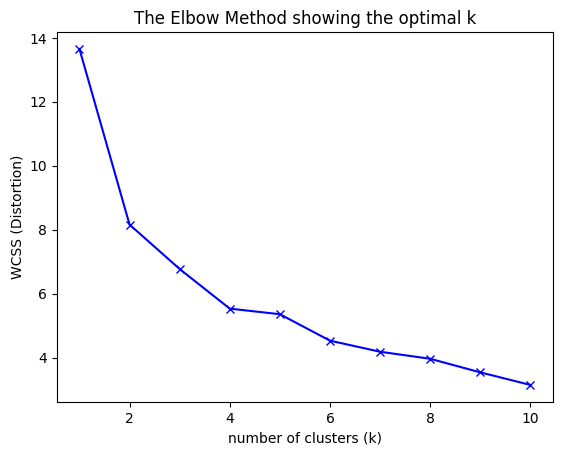

In [21]:
print("Distortions for each k:")
for key, val in mapping1.items():
    print(f"{key} : {val}")

plt.plot(K, distortions, 'bx-')
plt.xlabel('number of clusters (k)')
plt.ylabel('WCSS (Distortion)')
plt.title('The Elbow Method showing the optimal k')
plt.show()


Inertias for each k:
1 : 16648544.636032945
2 : 6100983.385914966
3 : 4146335.507029619
4 : 2904691.5560740405
5 : 2581521.8302984983
6 : 2003709.5325739381
7 : 1783367.0890468115
8 : 1542422.3860196406
9 : 1330564.9734401882
10 : 1058615.6923220316


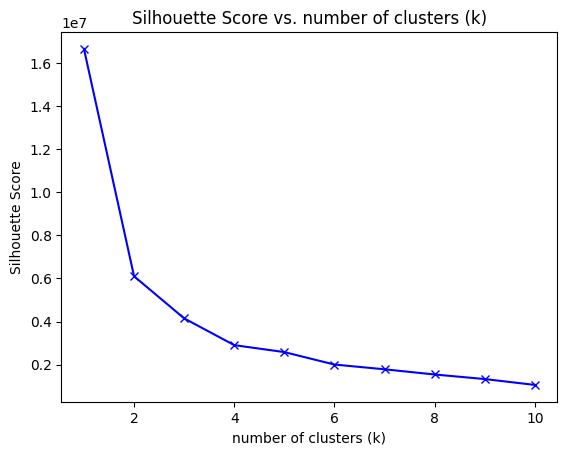

In [22]:
print("Inertias for each k:")
for key, val in mapping2.items():
    print(f"{key} : {val}")

plt.plot(K, inertias, 'bx-')
plt.xlabel('number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. number of clusters (k)')
plt.show()

In [23]:
# for K=6 as required

k = 6

model = KMeans(n_clusters=k, random_state=42)
model.fit(features)
labels = model.labels_
centroids = model.cluster_centers_
df['Cluster'] = labels
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,Cluster
0,-0.363636,2,0.272727,-0.6250,110,80,0,0,0,0,1,0,2
1,0.141414,1,-0.818182,0.8125,140,90,2,0,0,0,1,1,5
2,-0.232323,1,0.000000,-0.5000,130,70,2,0,0,0,0,1,3
3,-0.575758,2,0.363636,0.6250,150,100,0,0,0,0,1,1,0
5,0.606061,1,-1.272727,-0.3125,120,80,1,1,0,0,0,0,1


In [24]:
print(df['Cluster'].value_counts())

Cluster
1    25112
5    10219
4     7833
3     7816
0     7050
2     4560
Name: count, dtype: int64


###  DBSCAN clustering

In [25]:
# preforming Dimensionality Reduction using PCA


pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

In [26]:
# Fitting DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)

dbscan.fit(features_pca)

labels_dbscan = dbscan.labels_


In [27]:
dbscan_frame = features

In [28]:
dbscan_frame['DBSCAN_LABELS'] = labels_dbscan

In [29]:
dbscan_frame.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,DBSCAN_LABELS
0,-0.363636,2,0.272727,-0.6250,110,80,0,0,0,0,1,0
1,0.141414,1,-0.818182,0.8125,140,90,2,0,0,0,1,1
2,-0.232323,1,0.000000,-0.5000,130,70,2,0,0,0,0,2
3,-0.575758,2,0.363636,0.6250,150,100,0,0,0,0,1,3
5,0.606061,1,-1.272727,-0.3125,120,80,1,1,0,0,0,4


In [30]:
dbscan_frame.DBSCAN_LABELS.value_counts()

,count
DBSCAN_LABELS,
4,23133
1,5487
7,5405
5,4316
6,3147
...,...
82,5
97,5
93,5


In [31]:
outliers = dbscan_frame[dbscan_frame["DBSCAN_LABELS"] == -1]
print("Number of outliers:", len(outliers))
print("--------"*10)
outliers.head()

Number of outliers: 802
--------------------------------------------------------------------------------


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,DBSCAN_LABELS
94,-1.040404,2,1.818182,1.0000,133,89,1,2,0,0,1,-1
113,-0.212121,1,-0.727273,0.4375,125,65,0,1,0,0,1,-1
439,0.151515,2,1.272727,-0.4500,126,84,0,2,0,0,1,-1
499,0.626263,1,0.272727,-0.4375,158,91,0,0,0,0,1,-1
598,-1.444444,2,0.454545,1.5625,123,80,0,0,1,0,1,-1


In [32]:
# clustering = AgglomerativeClustering(n_clusters=3)
# labels = clustering.fit_predict(features)

# agg = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
# agg.fit(features)


In [33]:
features_gpu = cp.asarray(features)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    init='pca',
    random_state=42
)



features_tsne_gpu = tsne.fit_transform(features_gpu)

features_tsne = cp.asnumpy(features_tsne_gpu)

[2025-11-25 23:26:11.171] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


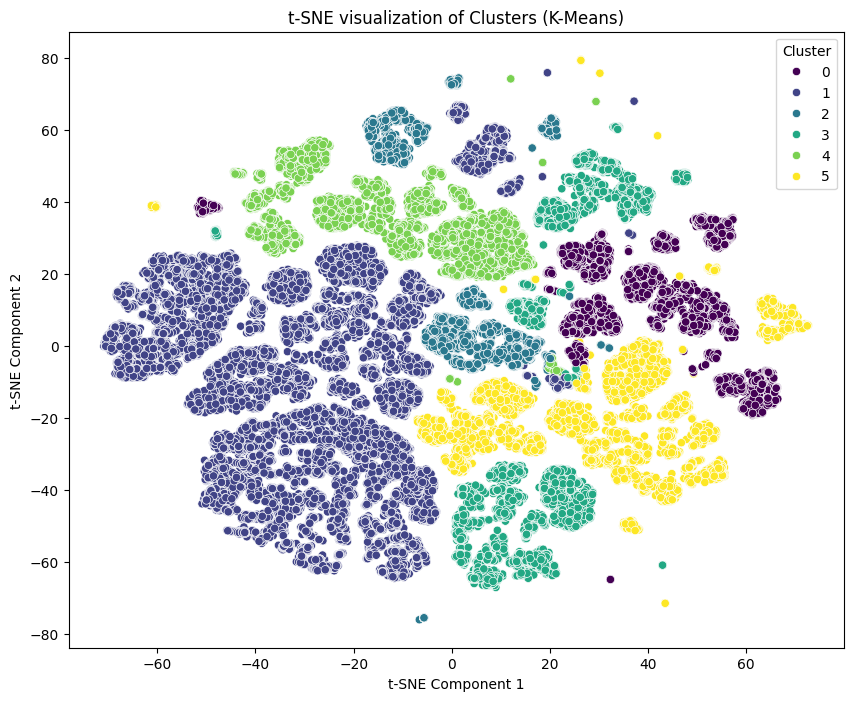

In [34]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=features_tsne[:, 0], y=features_tsne[:, 1],
    hue=df['Cluster'], palette='viridis', legend='full'
)
plt.title('t-SNE visualization of Clusters (K-Means)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [35]:
# plt.figure(figsize=(10, 8))
# sns.scatterplot(
#     x=features_tsne[:, 0], y=features_tsne[:, 1],
#     hue=df['HCLUST_LABEL'], palette='tab10', legend='full'
# )
# plt.title('t-SNE visualization of Clusters (Agglomerative Clustering)')
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.show()

In [36]:
cluster_profiles = df.groupby('Cluster').describe()
cluster_profiles

age                                                              \
           count      mean       std       min       25%       50%       75%   
Cluster                                                                        
0         7050.0  0.143735  0.628064 -1.494949 -0.242424  0.212121  0.626263   
1        25112.0 -0.103713  0.669746 -1.494949 -0.585859 -0.020202  0.414141   
2         4560.0 -0.324457  0.696796 -1.505051 -0.878788 -0.353535  0.202020   
3         7816.0  0.125143  0.634716 -1.505051 -0.252525  0.202020  0.616162   
4         7833.0 -0.277888  0.705147 -1.494949 -0.848485 -0.232323  0.252525   
5        10219.0  0.051182  0.643571 -1.494949 -0.393939  0.151515  0.585859   

                    gender            ... active        cardio            \
              max    count      mean  ...    75%  max    count      mean   
Cluster                               ...                                  
0        1.101010   7050.0  1.372199  ...    1.0  1.0   7050.0  0.861702   
1        1.111111  25112.0  1.362576  ...    1.0  1.0  25112.0  0.356841   
2        1.101010   4560.0  1.276974  ...    1.0  1.0   4560.0  0.230044   
3        1.101010   7816.0  1.344678  ...    1.0  1.0   7816.0  0.648414   
4        1.101010   7833.0  1.301928  ...    1.0  1.0   7833.0  0.261075   
5        1.090909  10219.0  1.369214  ...    1.0  1.0  10219.0  0.756238   

                                            
              std  min  25%  50%  75%  max  
Cluster                                     
0        0.345237  0.0  1.0  1.0  1.0  1.0  
1        0.479077  0.0  0.0  0.0  1.0  1.0  
2        0.420907  0.0  0.0  0.0  0.0  1.0  
3        0.477496  0.0  0.0  1.0  1.0  1.0  
4        0.439249  0.0  0.0  0.0  1.0  1.0  
5        0.429372  0.0  1.0  1.0  1.0  1.0  

[6 rows x 96 columns]

In [37]:
print('Profile DBSCAN Clusters')
dbscan_cluster_profiles = dbscan_frame.groupby('DBSCAN_LABELS').describe()
dbscan_cluster_profiles

Profile DBSCAN Clusters


age                                                    \
                count      mean       std       min       25%       50%   
DBSCAN_LABELS                                                             
-1              802.0  0.017582  0.661765 -1.494949 -0.404040  0.040404   
 0             2215.0 -0.277155  0.701448 -1.505051 -0.838384 -0.242424   
 1             5487.0  0.067603  0.642910 -1.494949 -0.383838  0.161616   
 2              590.0  0.081287  0.676688 -1.494949 -0.363636  0.196970   
 3             1006.0  0.078599  0.624443 -1.444444 -0.343434  0.161616   
...               ...       ...       ...       ...       ...       ...   
 102              5.0  0.046465  0.462313 -0.444444 -0.363636  0.010101   
 103              5.0  0.010101  0.731818 -1.090909 -0.343434  0.242424   
 104              8.0  0.527778  0.428507 -0.050505  0.194444  0.464646   
 105              6.0 -0.590909  0.356767 -1.070707 -0.866162 -0.424242   
 106              8.0 -0.481061  0.564158 -1.181818 -0.992424 -0.439394   

                                   gender            ...  alco       active  \
                    75%       max   count      mean  ...   75%  max   count   
DBSCAN_LABELS                                        ...                      
-1             0.575758  1.090909   802.0  1.316708  ...  0.00  1.0   802.0   
 0             0.232323  1.101010  2215.0  1.306998  ...  0.00  1.0  2215.0   
 1             0.595960  1.090909  5487.0  1.362129  ...  0.00  1.0  5487.0   
 2             0.616162  1.070707   590.0  1.366102  ...  0.00  1.0   590.0   
 3             0.595960  1.090909  1006.0  1.396620  ...  0.00  1.0  1006.0   
...                 ...       ...     ...       ...  ...   ...  ...     ...   
 102           0.464646  0.565657     5.0  1.600000  ...  0.00  1.0     5.0   
 103           0.575758  0.666667     5.0  1.400000  ...  0.00  0.0     5.0   
 104           0.992424  1.000000     8.0  1.250000  ...  0.00  0.0     8.0   
 105          -0.398990 -0.222222     6.0  1.000000  ...  0.75  1.0     6.0   
 106          -0.224747  0.353535     8.0  1.250000  ...  0.00  0.0     8.0   

                                                             
                   mean       std  min   25%  50%  75%  max  
DBSCAN_LABELS                                                
-1             0.785536  0.410706  0.0  1.00  1.0  1.0  1.0  
 0             0.828894  0.376687  0.0  1.00  1.0  1.0  1.0  
 1             0.808092  0.393837  0.0  1.00  1.0  1.0  1.0  
 2             0.755932  0.429898  0.0  1.00  1.0  1.0  1.0  
 3             0.804175  0.397032  0.0  1.00  1.0  1.0  1.0  
...                 ...       ...  ...   ...  ...  ...  ...  
 102           0.600000  0.547723  0.0  0.00  1.0  1.0  1.0  
 103           1.000000  0.000000  1.0  1.00  1.0  1.0  1.0  
 104           0.750000  0.462910  0.0  0.75  1.0  1.0  1.0  
 105           1.000000  0.000000  1.0  1.00  1.0  1.0  1.0  
 106           0.875000  0.353553  0.0  1.00  1.0  1.0  1.0  

[108 rows x 88 columns]

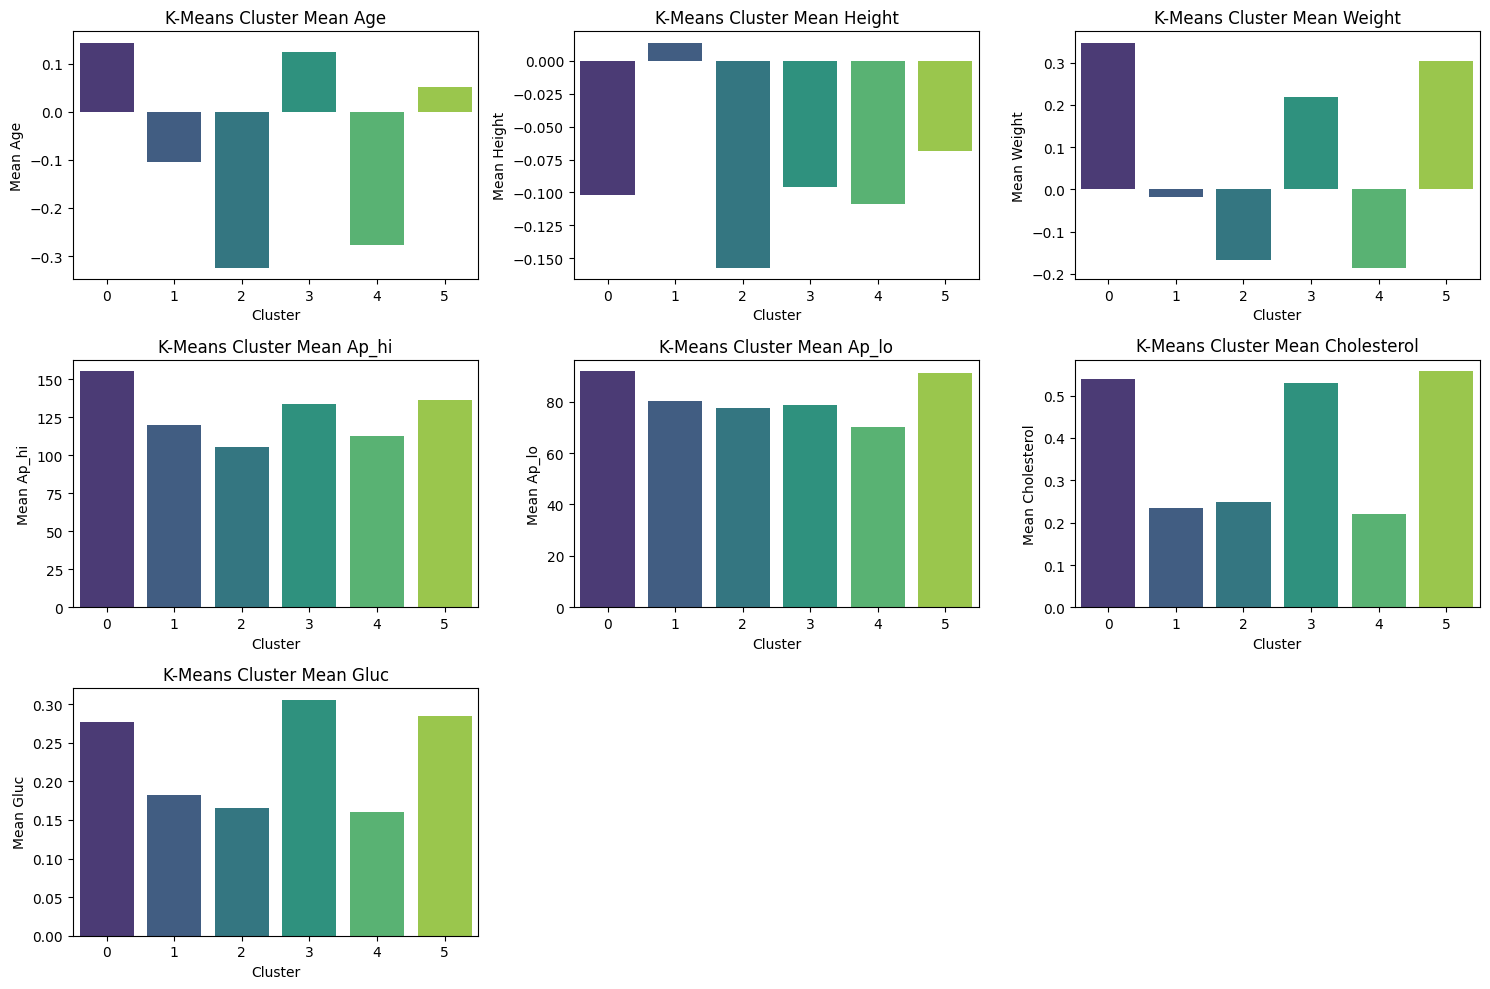

In [38]:

key_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc']

kmeans_mean_profiles = cluster_profiles.loc[:, (key_features, 'mean')]
kmeans_mean_profiles.columns = kmeans_mean_profiles.columns.droplevel(1)

# Plotting K-Means cluster profiles
plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features):
    plt.subplot(3, 3, i + 1)
    sns.barplot(x=kmeans_mean_profiles.index, y=kmeans_mean_profiles[feature], palette='viridis')
    plt.title(f'K-Means Cluster Mean {feature.capitalize()}')
    plt.xlabel('Cluster')
    plt.ylabel(f'Mean {feature.capitalize()}')
plt.tight_layout()
plt.show()

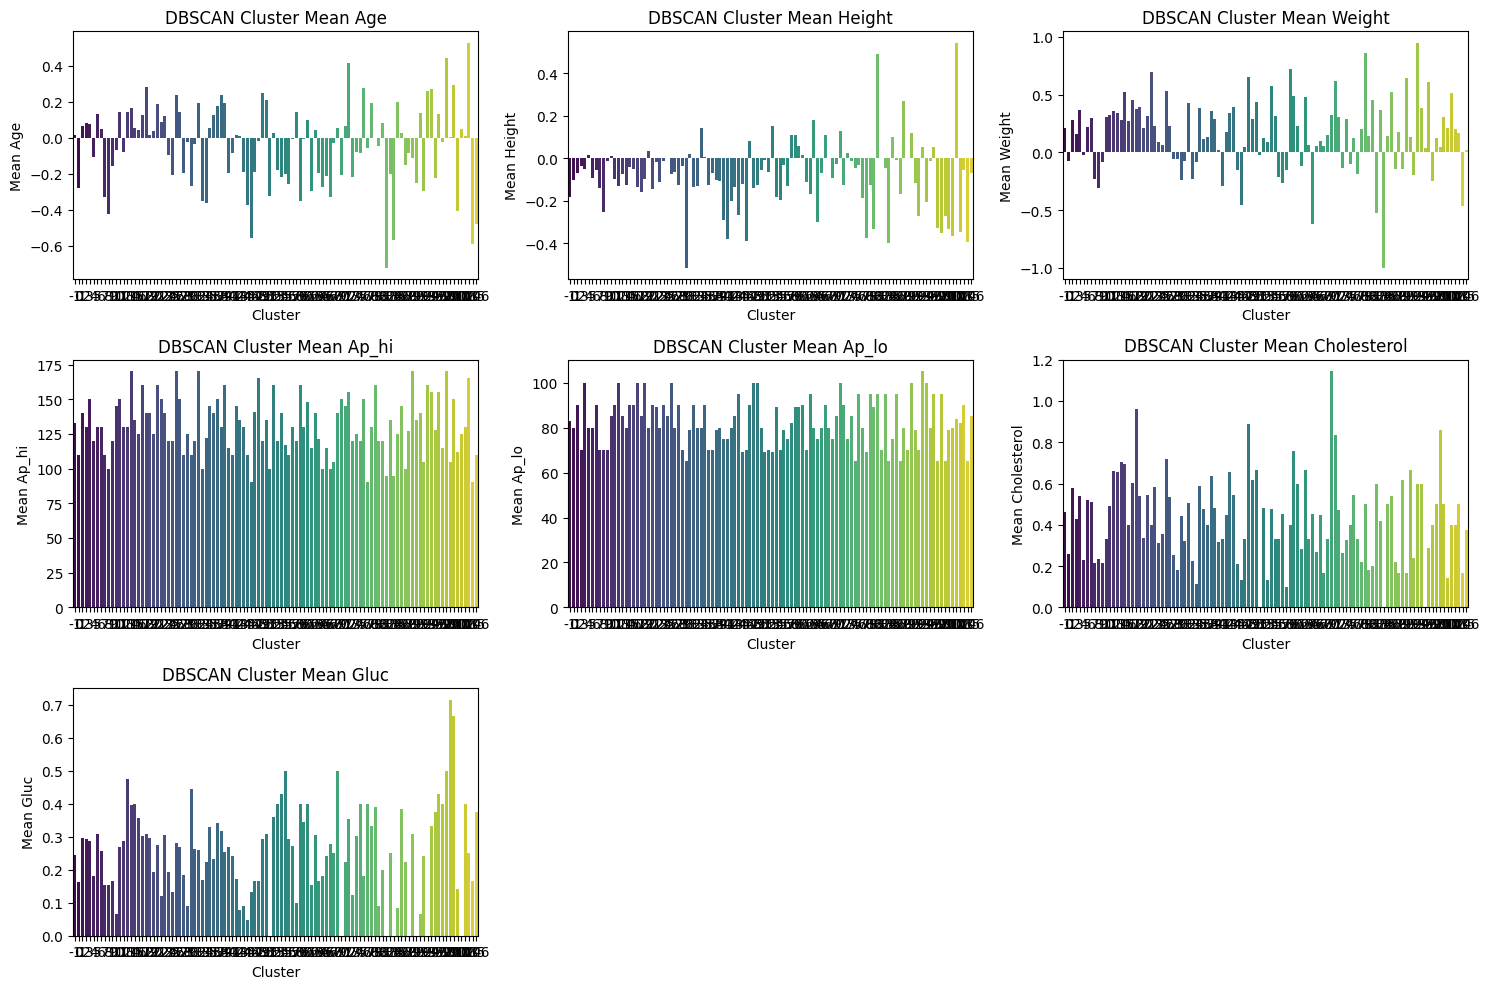

In [39]:
dbscan_mean_profiles = dbscan_cluster_profiles.loc[:, (key_features, 'mean')]
dbscan_mean_profiles.columns = dbscan_mean_profiles.columns.droplevel(1)

plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features):
    plt.subplot(3, 3, i + 1)
    sns.barplot(x=dbscan_mean_profiles.index, y=dbscan_mean_profiles[feature], palette='viridis')
    plt.title(f'DBSCAN Cluster Mean {feature.capitalize()}')
    plt.xlabel('Cluster')
    plt.ylabel(f'Mean {feature.capitalize()}')
plt.tight_layout()
plt.show()